In [1]:
"""
Model Training for HCV Disease Prediction
==========================================
Training multiple classification algorithms to predict HCV disease stages
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, confusion_matrix, classification_report,
                           roc_auc_score, roc_curve, auc)
from sklearn.model_selection import cross_val_score, GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# Set random seed
np.random.seed(42)

print("Libraries loaded successfully")

Libraries loaded successfully


In [2]:
# Load preprocessed data
data_dir = '../data/processed/'

X_train = pd.read_csv(f'{data_dir}X_train.csv')
X_val = pd.read_csv(f'{data_dir}X_val.csv')
X_test = pd.read_csv(f'{data_dir}X_test.csv')

y_train = pd.read_csv(f'{data_dir}y_train.csv')['Category']
y_val = pd.read_csv(f'{data_dir}y_val.csv')['Category']
y_test = pd.read_csv(f'{data_dir}y_test.csv')['Category']

print("Data shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

print(f"\nClass distribution in training (balanced with SMOTE):")
print(y_train.value_counts().sort_index())

Data shapes:
X_train: (1264, 22), y_train: (1264,)
X_val: (118, 22), y_val: (118,)
X_test: (118, 22), y_test: (118,)

Class distribution in training (balanced with SMOTE):
Category
0    316
1    316
2    316
3    316
Name: count, dtype: int64


In [3]:
class ModelTrainer:
    def __init__(self):
        self.models = {}
        self.results = {}
        self.best_model = None
        self.best_score = 0

    def select_model(self, name, model):
        self.models[name] = model

    def train_model(self, name, X_train, y_train, X_val, y_val):
        """Train a single model and evaluate on validation set"""

        print(f"\nTraining {name}...")
        start_time = time.time()

        # Train
        model = self.models[name]
        model.fit(X_train, y_train)

        # Predict
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        
        # Calculate metrics
        train_acc = accuracy_score(y_train, y_train_pred)
        val_acc = accuracy_score(y_val, y_val_pred)
        val_f1 = f1_score(y_val, y_val_pred, average='weighted')
        val_precision = precision_score(y_val, y_val_pred, average='weighted', zero_division=0)
        val_recall = recall_score(y_val, y_val_pred, average='weighted')
        
        # Training time
        training_time = time.time() - start_time
        
        # Store results
        self.results[name] = {
            'model': model,
            'train_accuracy': train_acc,
            'val_accuracy': val_acc,
            'val_f1': val_f1,
            'val_precision': val_precision,
            'val_recall': val_recall,
            'training_time': training_time,
            'y_val_pred': y_val_pred
        }
        
        print(f"  Training Accuracy: {train_acc:.4f}")
        print(f"  Validation Accuracy: {val_acc:.4f}")
        print(f"  Validation F1-Score: {val_f1:.4f}")
        print(f"  Training Time: {training_time:.2f} seconds")
        
        # Update best model
        if val_f1 > self.best_score:
            self.best_score = val_f1
            self.best_model = name
            
        return model
    
    def train_all(self, X_train, y_train, X_val, y_val):
        """Train all models"""
        for name in self.models.keys():
            self.train_model(name, X_train, y_train, X_val, y_val)
        
        print(f"\nBest Model: {self.best_model} (F1-Score: {self.best_score:.4f})")
        
    def get_results_dataframe(self):
        """Return results as a sorted dataframe"""
        df = pd.DataFrame(self.results).T
        df = df.sort_values('val_f1', ascending=False)
        return df[['train_accuracy', 'val_accuracy', 'val_f1', 'val_precision', 'val_recall', 'training_time']]

In [4]:
# Initialize trainer and add models
trainer = ModelTrainer()

# Add models to compare
trainer.select_model('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42))
trainer.select_model('Decision Tree', DecisionTreeClassifier(random_state=42))
trainer.select_model('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42))
trainer.select_model('XGBoost', XGBClassifier(random_state=42, eval_metric='mlogloss'))
trainer.select_model('SVM', SVC(kernel='rbf', random_state=42))

print("Models initialized:")
for name in trainer.models.keys():
    print(f"  - {name}")


Models initialized:
  - Logistic Regression
  - Decision Tree
  - Random Forest
  - XGBoost
  - SVM


In [5]:
# Training all models 

print("="*60)
print("TRAINING MODELS")
print("="*60)

trainer.train_all(X_train, y_train, X_val, y_val)

# Display results summary
print("\n" + "="*60)
print("RESULTS SUMMARY")
print("="*60)
results_df = trainer.get_results_dataframe()
print(results_df.round(4))

TRAINING MODELS

Training Logistic Regression...
  Training Accuracy: 0.9984
  Validation Accuracy: 0.9237
  Validation F1-Score: 0.9291
  Training Time: 0.18 seconds

Training Decision Tree...
  Training Accuracy: 1.0000
  Validation Accuracy: 0.9492
  Validation F1-Score: 0.9413
  Training Time: 0.07 seconds

Training Random Forest...
  Training Accuracy: 1.0000
  Validation Accuracy: 0.9576
  Validation F1-Score: 0.9478
  Training Time: 0.98 seconds

Training XGBoost...
  Training Accuracy: 1.0000
  Validation Accuracy: 0.9492
  Validation F1-Score: 0.9356
  Training Time: 0.64 seconds

Training SVM...
  Training Accuracy: 0.9960
  Validation Accuracy: 0.9237
  Validation F1-Score: 0.9239
  Training Time: 0.26 seconds

Best Model: Random Forest (F1-Score: 0.9478)

RESULTS SUMMARY
                    train_accuracy val_accuracy    val_f1 val_precision  \
Random Forest                  1.0     0.957627   0.94776      0.939547   
Decision Tree                  1.0     0.949153   0.9413

In [6]:
trainer.get_results_dataframe()

,train_accuracy,val_accuracy,val_f1,val_precision,val_recall,training_time
Random Forest,1.0,0.957627,0.94776,0.939547,0.957627,0.975046
Decision Tree,1.0,0.949153,0.94133,0.936441,0.949153,0.068793
XGBoost,1.0,0.949153,0.935579,0.924651,0.949153,0.644742
Logistic Regression,0.998418,0.923729,0.92908,0.9375,0.923729,0.178438
SVM,0.996044,0.923729,0.923944,0.926907,0.923729,0.258733


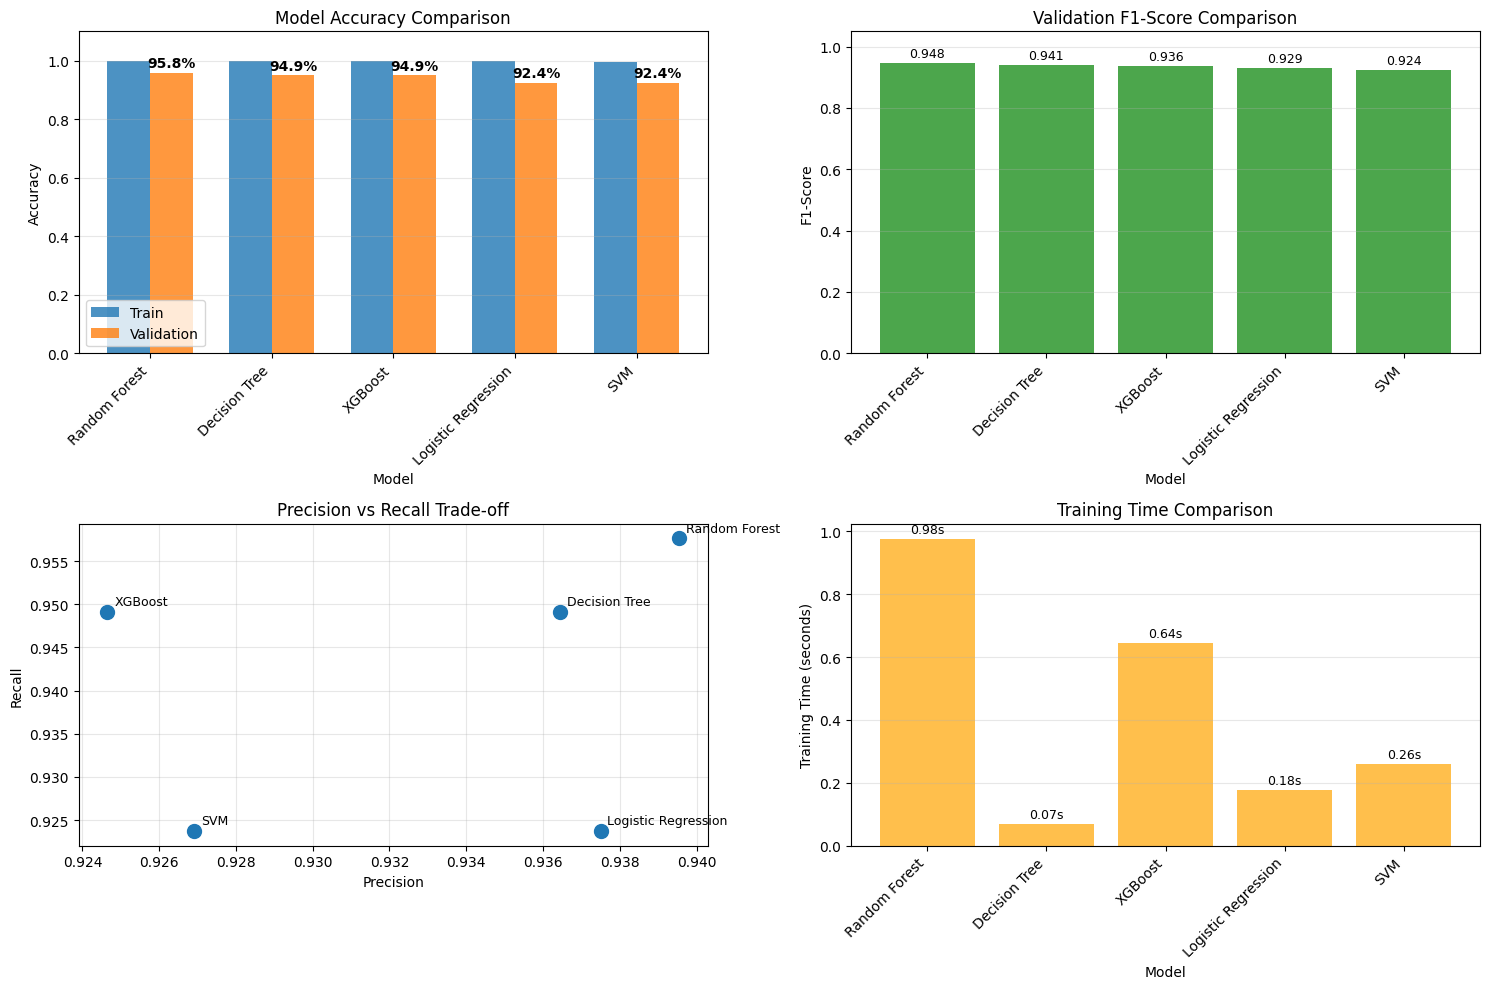


BASELINE COMPARISON
Baseline accuracy (always predict healthy): 89.0%

Improvement over baseline:
  Random Forest: 95.8% (+6.8% over baseline)
  Decision Tree: 94.9% (+5.9% over baseline)
  XGBoost: 94.9% (+5.9% over baseline)
  Logistic Regression: 92.4% (+3.4% over baseline)
  SVM: 92.4% (+3.4% over baseline)


In [7]:
# Visualize model performance
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy comparison with values
ax = axes[0, 0]
models = results_df.index
x_pos = np.arange(len(models))
train_acc = results_df['train_accuracy'].values
val_acc = results_df['val_accuracy'].values

width = 0.35
bars1 = ax.bar(x_pos - width/2, train_acc, width, label='Train', alpha=0.8)
bars2 = ax.bar(x_pos + width/2, val_acc, width, label='Validation', alpha=0.8)

# Add value labels on validation bars
for i, (bar, val) in enumerate(zip(bars2, val_acc)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{val:.1%}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy Comparison')
ax.set_xticks(x_pos)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1.1)  # Extend y-axis to make room for labels

# F1-Score comparison
ax = axes[0, 1]
bars = ax.bar(models, results_df['val_f1'].values, color='green', alpha=0.7)
# Add value labels on F1 bars
for bar, val in zip(bars, results_df['val_f1'].values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{val:.3f}', ha='center', va='bottom', fontsize=9)
ax.set_xlabel('Model')
ax.set_ylabel('F1-Score')
ax.set_title('Validation F1-Score Comparison')
ax.set_xticklabels(models, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1.05)

# Precision vs Recall
ax = axes[1, 0]
ax.scatter(results_df['val_precision'], results_df['val_recall'], s=100)
for i, model in enumerate(models):
    ax.annotate(model, (results_df['val_precision'].iloc[i], results_df['val_recall'].iloc[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=9)
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_title('Precision vs Recall Trade-off')
ax.grid(alpha=0.3)

# Training time
ax = axes[1, 1]
bars = ax.bar(models, results_df['training_time'].values, color='orange', alpha=0.7)
# Add value labels on time bars
for bar, val in zip(bars, results_df['training_time'].values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{val:.2f}s', ha='center', va='bottom', fontsize=9)
ax.set_xlabel('Model')
ax.set_ylabel('Training Time (seconds)')
ax.set_title('Training Time Comparison')
ax.set_xticklabels(models, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../images/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Print baseline comparison
print("\n" + "="*60)
print("BASELINE COMPARISON")
print("="*60)
baseline_acc = (y_val == 0).sum() / len(y_val)
print(f"Baseline accuracy (always predict healthy): {baseline_acc:.1%}")
print(f"\nImprovement over baseline:")
for model in results_df.index:
    val_acc = results_df.loc[model, 'val_accuracy']
    improvement = val_acc - baseline_acc
    print(f"  {model}: {val_acc:.1%} ({improvement:+.1%} over baseline)")